In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import geopandas as gpd
import matplotlib as mpl
import requests
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from pandas.api.types import is_numeric_dtype

plt.rcParams.update({'font.size': 22})

## Functions

In [2]:
def regress(data, yvar, xvars):
    Y = data[yvar]
    X = data[xvars]
    X['intercept'] = 1.
    result = sm.OLS(Y, X).fit()
    residual_var = result.mse_resid
    return pd.Series([result.params[0], result.rsquared, residual_var])

def plot_map(data, column, title, cmap, cbar_label, norm, filename):
    fig, ax = plt.subplots(1, 1, figsize=(20, 15))
    merged = countries.merge(data, how="left")

    plot_args = dict(column=column, ax=ax, legend=True, cmap=cmap, 
                     missing_kwds={'color': 'lightgrey'})

    if norm is not None:
        plot_args["norm"] = norm

    if is_numeric_dtype(merged[column]) and cbar_label is not None:
        plot_args["legend_kwds"] = {'label': "Correspondance Index",
                        'orientation': "horizontal", 'pad': -0.01}


    merged.plot(**plot_args)
    ax.set_title(title)
    ax.set_axis_off()

    if {"sif_coefficient", "pos_neg"} <= set(merged.columns):
        merged.loc[merged.sif_coefficient<1].plot(column="pos_neg", hatch = "//", ax=ax, facecolor="none", edgecolor="white")
    else:
        pass

    plt.savefig(f"./plots/{filename}.pdf", bbox_inches='tight')
    plt.show()
    plt.close()

## Input data, clean to match country ID, run regression

In [3]:
## load in global map, identify mismatches with my country IDs
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries = countries.rename({"name":"country"}, axis=1)
countries = countries[countries['continent']!= "Antarctica"]
countries.loc[countries.country=="France", 'iso_a3'] = "FRA"
countries.loc[countries.country=="Norway", 'iso_a3'] = "NOR"
mollweide_proj = '+proj=moll +lon_0=0'
countries = countries.to_crs(mollweide_proj)

c= ['Bosnia and Herz.', 'Central African Rep.',"Côte d'Ivoire", 'Dem. Rep. Congo', "eSwatini", "Laos", 'Macedonia', 'Moldova', 'North Korea', 
'Russia','South Korea', 'Syria', 'Tanzania', 'Vietnam', "United Kingdom"]
mustfix = ["Bosnia and Herzegovina", "Central African Republic", "Côte d'Ivoire", "Democratic Republic of the Congo","Eswatini", "Lao People's Democratic Republic",
           "North Macedonia", "Republic of Moldova", "Democratic People's Republic of Korea", "Russian Federation", "Republic of Korea", 
           "Syrian Arab Republic", "United Republic of Tanzania", "Viet Nam", "United Kingdom of Great Britain and Northern Ireland"]
changes = pd.DataFrame({"country": mustfix, "fixed":c})

## match up map names with my DF names
combined = pd.read_pickle("./data/yield_comparison.pkl").dropna()
combined["country"] = combined["country"].str.replace(r"[,(].*", "", regex=True).str.strip()
combined = combined.merge(changes, how="left")
combined.loc[combined.fixed.notnull(), 'country'] = combined.fixed

## run regression of yield against csif for each country/crop
regs = combined.groupby(['country', 'cropname']).apply(regress, 'yield', ['csif'])
regs.columns=["sif_coefficient", "r2", "resid_var"]
regs = regs.reset_index().dropna()
regs.replace([np.inf, -np.inf], np.nan, inplace=True)
regs["sif_coefficient"] = np.sign(regs["sif_coefficient"])

## determine the majority sign of the SIF coefficient for each country, and average R2
sif_sign = (regs.groupby("country")["sif_coefficient"].agg(pd.Series.mode).reset_index()
    .explode("sif_coefficient")
    .groupby("country")
    .mean().reset_index()
    .assign(pos_neg=lambda d: np.where(d["sif_coefficient"] < 1, "neg", "pos")))
avg_r2 = regs.groupby('country')['r2'].mean().reset_index()
regs_avg = sif_sign.merge(avg_r2)
regs_best = regs.loc[regs.groupby('country')["r2"].idxmax()]

## fetch GDP data
url = "https://api.worldbank.org/v2/country/all/indicator/NY.GDP.PCAP.CD"
params = {"date": "2000:2023","format": "json", "per_page": 20000}

response = requests.get(url, params=params)

if response.status_code == 200:
    data = response.json()
    if len(data) > 1:
        records = data[1] 
        gdp_df = pd.DataFrame(records)
        gdp_df = gdp_df[["countryiso3code", "date", "value"]]
        gdp_df.columns = ["iso_a3", "year", "value"]
        gdp_df = gdp_df.groupby('iso_a3').mean('value').reset_index()
    else:
        print("No data found in the API response.")
else:
    print(f"Failed to fetch data. Status code: {response.status_code}")

## lead/lag analysis
leadlag = (pd.DataFrame(combined[["cropname", "country", "whichlag"]].drop_duplicates().reset_index(drop=True)
                  .groupby('country')['whichlag'].value_counts(normalize=True).round(2))
                  .rename(columns={'whichlag':'pct'}).reset_index().drop_duplicates())

leadlag_majority = leadlag.groupby('country')['pct'].idxmax()
leadlag_cat = leadlag.loc[leadlag_majority.dropna()]

leadlag_pct = leadlag.copy()
leadlag_pct['whichlag'] = leadlag_pct['whichlag'].replace({'yield_lag': 'lead/lag', 'yield_lead': 'lead/lag'})
leadlag_pct = leadlag_pct.groupby(['country', 'whichlag']).sum('pct').reset_index()
leadlag_pct = leadlag_pct[leadlag_pct['whichlag']=="lead/lag"]
leadlag_pct['pct'] = 1-leadlag_pct['pct']


## Plots

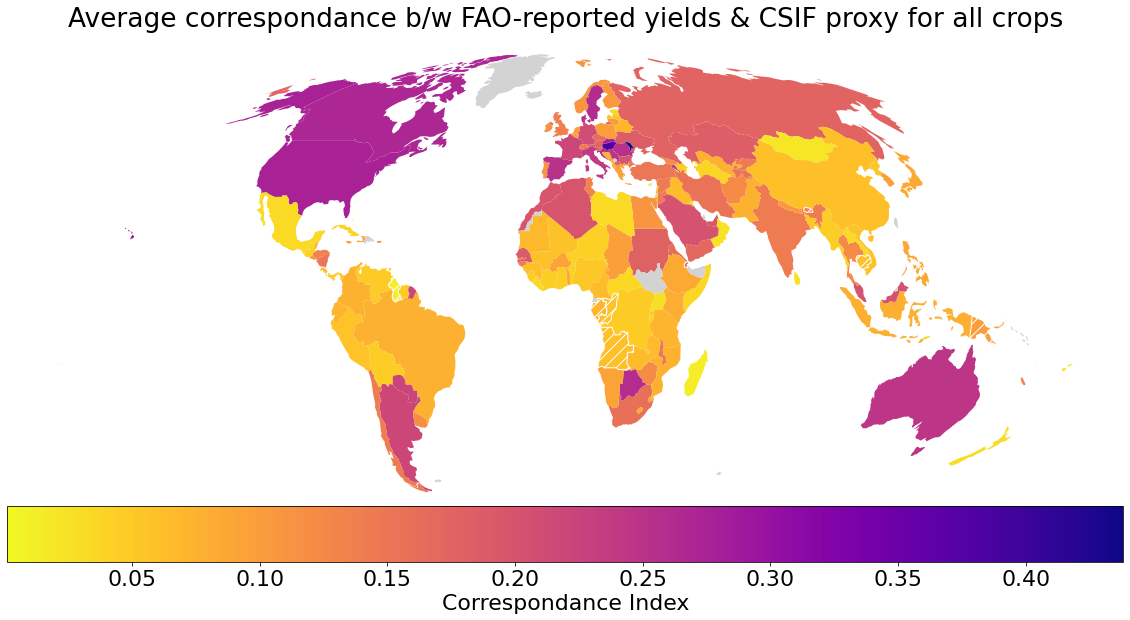

In [4]:
plot_map(regs_avg, column="r2", 
         title="Average correspondance b/w FAO-reported yields & CSIF proxy for all crops", 
         cmap="plasma_r", cbar_label="Averaged Correspondance Index", norm=None,
         filename="avg_corr_map")

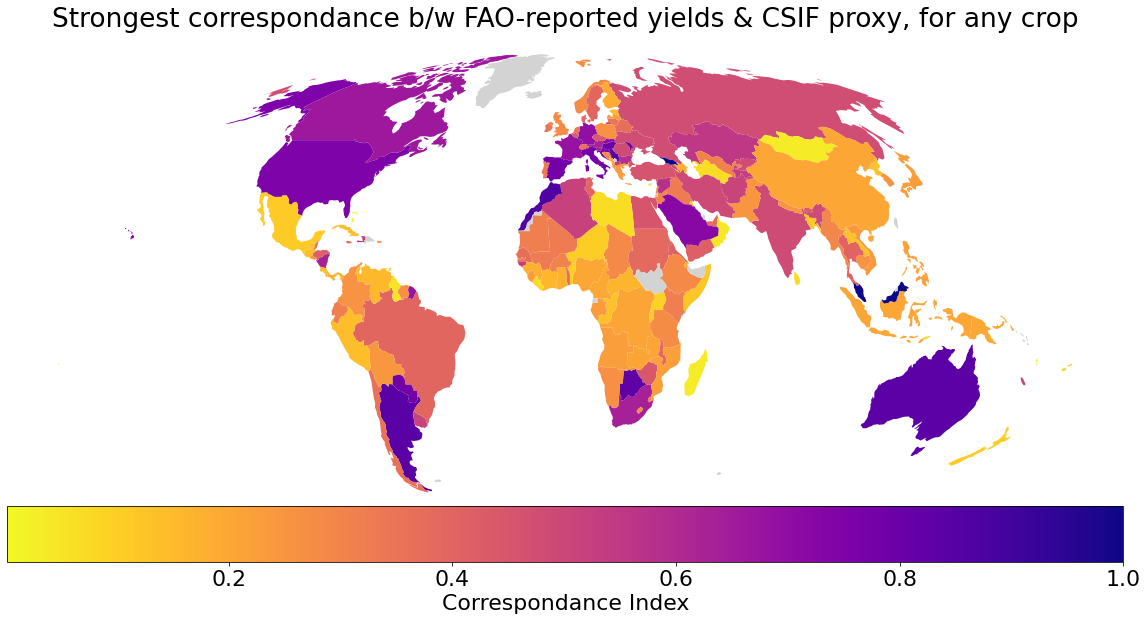

In [5]:
plot_map(regs_best, column="r2", 
         title="Strongest correspondance b/w FAO-reported yields & CSIF proxy, for any crop", 
         cmap="plasma_r", cbar_label="Correspondance Index", norm=None,
         filename="best_corr_map")

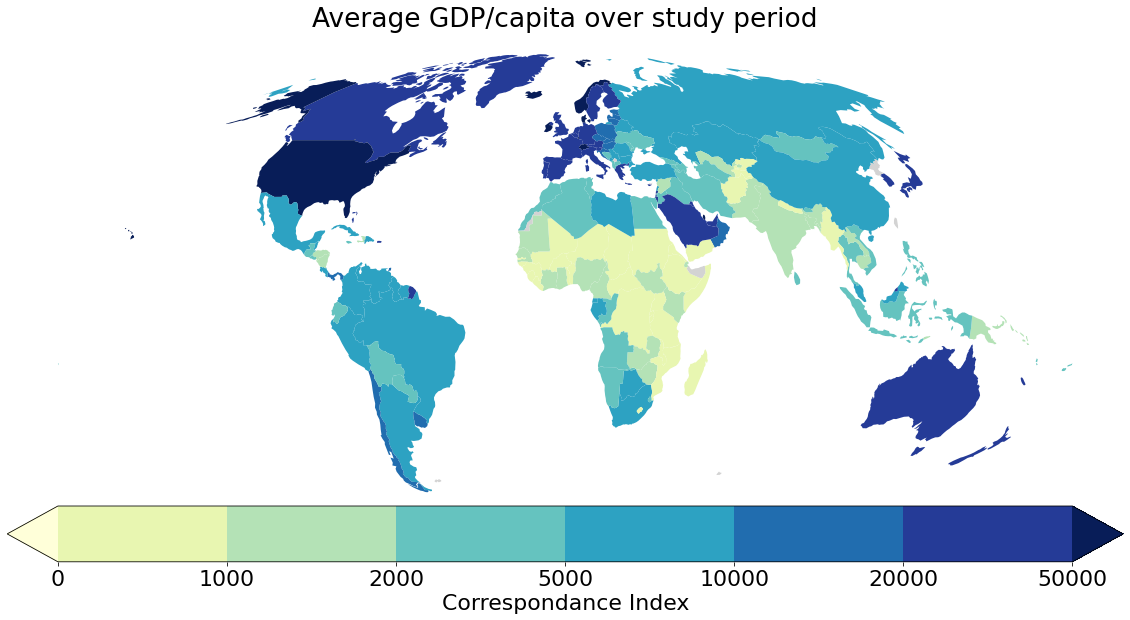

In [6]:
bounds = [0, 1000, 2000, 5000, 10000, 20000, 50000]
cmap = plt.cm.YlGnBu
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='both')

plot_map(gdp_df, column="value", 
         title="Average GDP/capita over study period", 
         cmap="YlGnBu", cbar_label="Average GDP/capita", norm=norm,
         filename="avg_gdp_map")

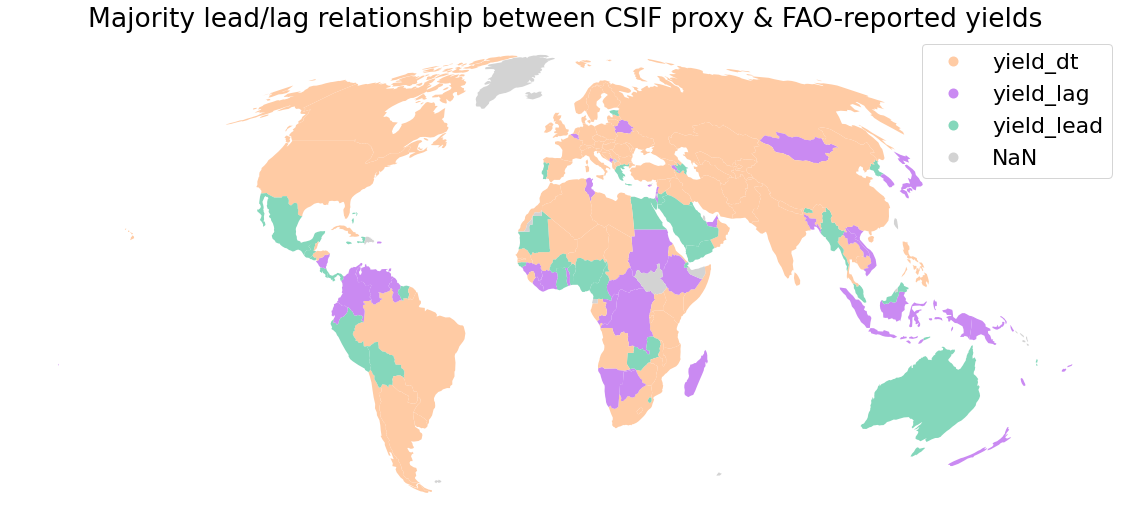

In [7]:
colors = ["#ffcba4", "#ca8af2", "#84d7bb"]
newcmp = ListedColormap(colors)

plot_map(leadlag_cat, column="whichlag", 
         title="Majority lead/lag relationship between CSIF proxy & FAO-reported yields", 
         cmap=newcmp, cbar_label=None, norm=None,
         filename="leadlag_map")

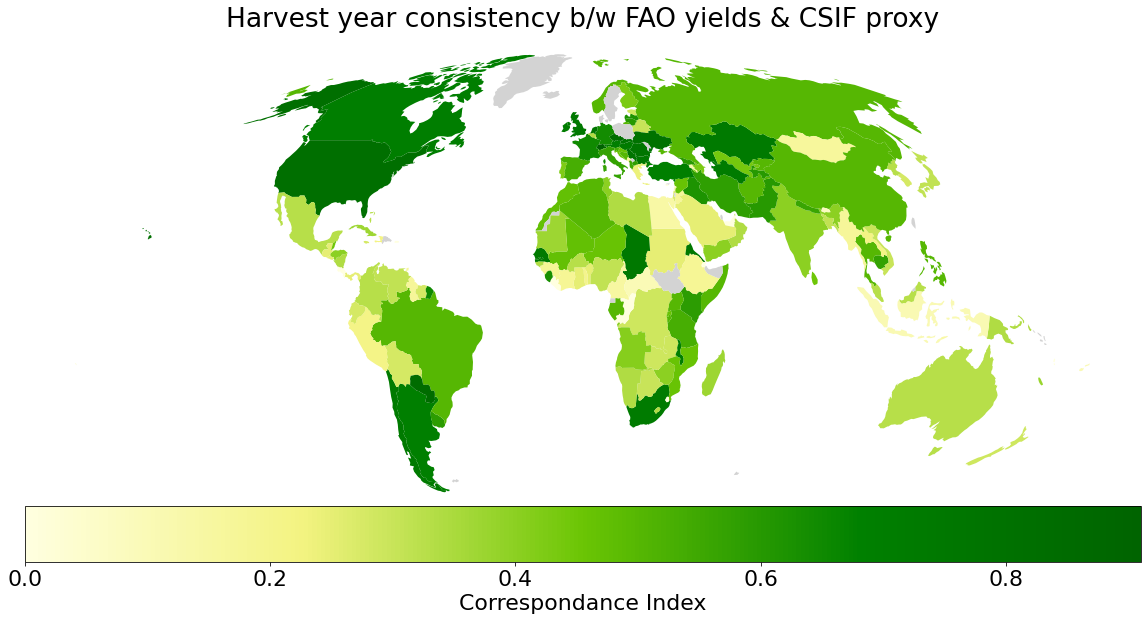

In [8]:
colors = ["lightyellow", "#f3f380", "#6bc504", "green", "darkgreen"]
new_cmap = mcolors.LinearSegmentedColormap.from_list("YellowToGreen", colors)

plot_map(leadlag_pct, column="pct", 
         title="Harvest year consistency b/w FAO yields & CSIF proxy", 
         cmap=new_cmap, cbar_label="Percentage of crop yields with consistent harvest years", norm=None,
         filename="leadlag_pct_map")
